In [1]:
# ### CELL 1 - Install required packages (run first)
! pip install --quiet lightgbm xgboost shap lime scikit-learn imbalanced-learn matplotlib pandas numpy joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# ### CELL 2 - Imports and output folder
import os
OUT = '/content/credit_project_outputs'
os.makedirs(OUT, exist_ok=True)
import io
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import shap
from lime.lime_tabular import LimeTabularExplainer


# For reproducibility
RND = 42

In [7]:
# ### CELL 3 - Download UCI German Credit dataset
# We'll download the original (categorical) german.data and attribute names are known.
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
print('Downloading dataset from UCI...')
import urllib.request
raw = urllib.request.urlopen(url).read().decode('latin-1')
# The file has 1000 rows, whitespace-separated, last column is class (1=good,2=bad)
rows = [r.strip() for r in raw.splitlines() if r.strip()]


# Column names (from dataset description)
cols = [
'Status_checking_account', 'Duration_months', 'Credit_history', 'Purpose', 'Credit_amount',
'Savings_account_bonds', 'Present_employment_since', 'Installment_rate', 'Personal_status_sex',
'Other_debtors_guarantors', 'Present_residence_since', 'Property', 'Age_years', 'Other_installment_plans',
'Housing', 'Number_existing_credits', 'Job', 'Number_people_liable', 'Telephone', 'Foreign_worker', 'Class'
]


# parse
data = [r.split() for r in rows]
# some tokens like purpose are single tokens; dataset consistent with 21 tokens per line
df = pd.DataFrame(data, columns=cols)
print('Downloaded rows:', df.shape[0])

Downloaded rows: 1000


In [8]:
# ### CELL 4 - Clean & typed dataframe
# Convert numeric columns to numeric types
num_cols = ['Duration_months','Credit_amount','Installment_rate','Present_residence_since','Age_years','Number_existing_credits','Number_people_liable']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')


# Map class to default: in UCI 1=good, 2=bad -> default = (value==2)
df['default'] = (df['Class']=='2').astype(int)
# Drop original class
df = df.drop(columns=['Class'])


# Quick sanity
print('Default distribution (1=default):', df['default'].value_counts().to_dict())

Default distribution (1=default): {0: 700, 1: 300}


In [9]:
# ### CELL 5 - Feature engineering & preprocessing plan (explainable choices)
# We'll keep categorical features as-is and One-Hot encode; numeric features will be scaled.
cat_cols = [c for c in df.columns if c not in num_cols + ['default']]


print('Numeric cols:', num_cols)
print('Categorical cols:', cat_cols)

Numeric cols: ['Duration_months', 'Credit_amount', 'Installment_rate', 'Present_residence_since', 'Age_years', 'Number_existing_credits', 'Number_people_liable']
Categorical cols: ['Status_checking_account', 'Credit_history', 'Purpose', 'Savings_account_bonds', 'Present_employment_since', 'Personal_status_sex', 'Other_debtors_guarantors', 'Property', 'Other_installment_plans', 'Housing', 'Job', 'Telephone', 'Foreign_worker']


In [10]:
# ### CELL 6 - Train/val/test split
X = df.drop(columns=['default']).copy()
y = df['default'].copy()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RND)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RND)

In [11]:
# ### CELL 7 - Preprocessing pipeline
numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_cols), ('cat', categorical_transformer, cat_cols)], remainder='drop')
preprocessor.fit(X_train)


X_train_p = preprocessor.transform(X_train)
X_val_p = preprocessor.transform(X_val)
X_test_p = preprocessor.transform(X_test)


# feature names
feature_names = list(num_cols) + list(preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols))
print('Feature count after preprocessing:', len(feature_names))

Feature count after preprocessing: 61


In [12]:
# ### CELL 8 - Handle class imbalance (SMOTE) and prepare training matrix
sm = SMOTE(random_state=RND)
X_train_res, y_train_res = sm.fit_resample(X_train_p, y_train)
print('After SMOTE class counts:', np.bincount(y_train_res))

After SMOTE class counts: [490 490]


In [13]:
# ### CELL 9 - Model training & hyperparameter tuning (LightGBM)
clf = lgb.LGBMClassifier(objective='binary', random_state=RND, n_jobs=1)
param_dist = {
'num_leaves':[15,31,63,127],
'n_estimators':[100,200,400,800],
'learning_rate':[0.001,0.01,0.05,0.1],
'min_child_samples':[5,10,20,50],
'subsample':[0.6,0.8,1.0],
'colsample_bytree':[0.6,0.8,1.0]
}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RND)
rs = RandomizedSearchCV(clf, param_dist, n_iter=40, scoring='roc_auc', cv=cv, random_state=RND, verbose=1)
rs.fit(X_train_res, y_train_res)
best = rs.best_estimator_
print('Best params:', rs.best_params_)


# Save baseline model
joblib.dump(best, os.path.join(OUT,'best_model_lgb.joblib'))

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

['/content/credit_project_outputs/best_model_lgb.joblib']

In [14]:
# ### CELL 10 - Evaluate and threshold tuning
probs_val = best.predict_proba(X_val_p)[:,1]
preds_val = (probs_val >= 0.5).astype(int)
metrics_val = {'auc': roc_auc_score(y_val, probs_val), 'f1': f1_score(y_val, preds_val), 'precision': precision_score(y_val, preds_val), 'recall': recall_score(y_val, preds_val)}
print('Validation metrics:', metrics_val)


probs_test = best.predict_proba(X_test_p)[:,1]
preds_test = (probs_test >= 0.5).astype(int)
metrics_test = {'auc': roc_auc_score(y_test, probs_test), 'f1': f1_score(y_test, preds_test), 'precision': precision_score(y_test, preds_test), 'recall': recall_score(y_test, preds_test)}
print('Test metrics:', metrics_test)


# Threshold tuning for business preference (maximize F1)
thresholds = np.linspace(0.01,0.99,99)
best_thr, best_f1 = 0.5, 0
for t in thresholds:
    p = (probs_val >= t).astype(int)
    f = f1_score(y_val, p)
    if f > best_f1:
        best_f1 = f; best_thr = t
print('Best threshold by F1 on val:', best_thr, 'F1:', best_f1)


# Save chosen threshold
with open(os.path.join(OUT,'chosen_threshold.txt'),'w') as f:
    f.write(str(best_thr))

Validation metrics: {'auc': np.float64(0.7401058201058202), 'f1': 0.47191011235955055, 'precision': 0.4772727272727273, 'recall': 0.4666666666666667}
Test metrics: {'auc': np.float64(0.7862433862433862), 'f1': 0.5066666666666667, 'precision': 0.6333333333333333, 'recall': 0.4222222222222222}
Best threshold by F1 on val: 0.43 F1: 0.5871559633027523


In [15]:
# ### CELL 11 - Model calibration (Platt)
from sklearn.calibration import CalibratedClassifierCV
cal = CalibratedClassifierCV(best, cv='prefit', method='sigmoid')
cal.fit(X_val_p, y_val)
joblib.dump(cal, os.path.join(OUT,'calibrated_model.joblib'))


# Evaluate calibrated model
probs_test_cal = cal.predict_proba(X_test_p)[:,1]
print('Calibrated Test AUC:', roc_auc_score(y_test, probs_test_cal))

Calibrated Test AUC: 0.7862433862433862


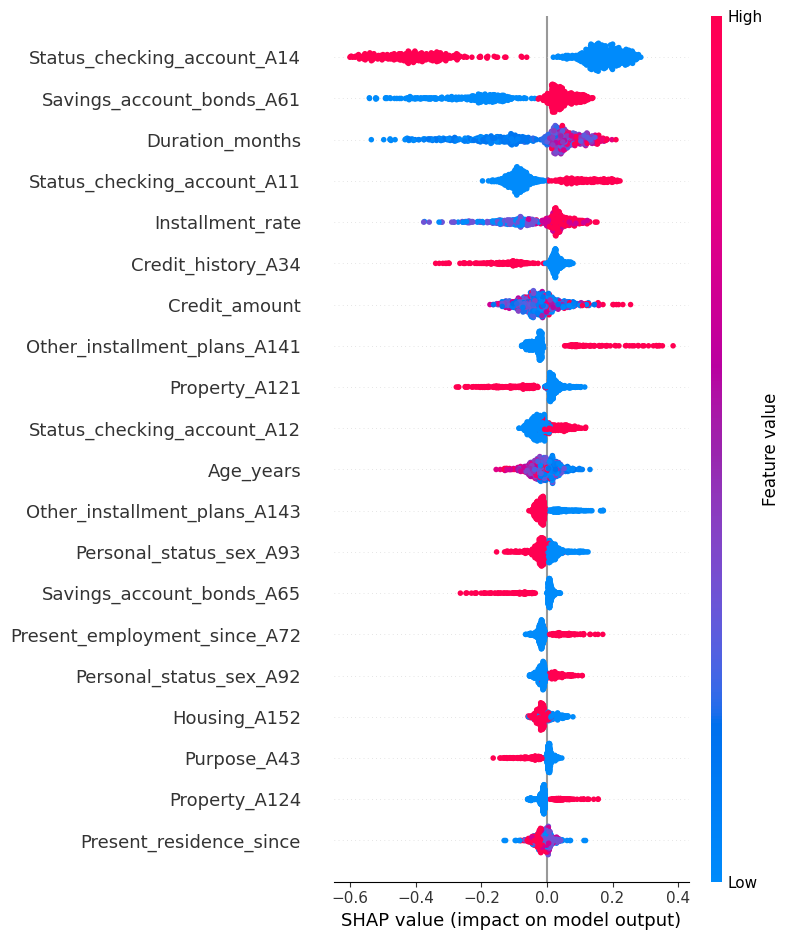

In [16]:
# ### CELL 12 - SHAP global & local explanations
explainer = shap.TreeExplainer(best)
shap_vals_train = explainer.shap_values(X_train_p)
shap_arr = shap_vals_train[1] if isinstance(shap_vals_train, list) else shap_vals_train
mean_abs_shap = np.mean(np.abs(shap_arr), axis=0)
shap_df = pd.DataFrame({'feature':feature_names, 'mean_abs_shap': mean_abs_shap}).sort_values('mean_abs_shap', ascending=False)
shap_df.to_csv(os.path.join(OUT,'global_shap_all.csv'), index=False)


# SHAP summary plot (static)
plt.figure(figsize=(10,6))
shap.summary_plot(shap_arr, features=X_train_p, feature_names=feature_names, show=False)
plt.tight_layout(); plt.savefig(os.path.join(OUT,'shap_summary.png'))

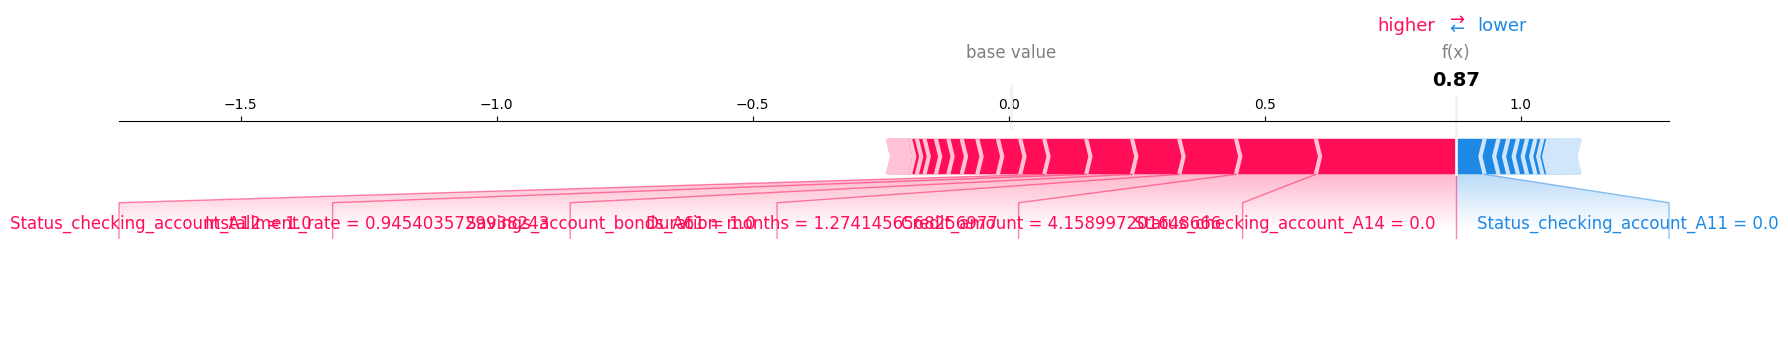

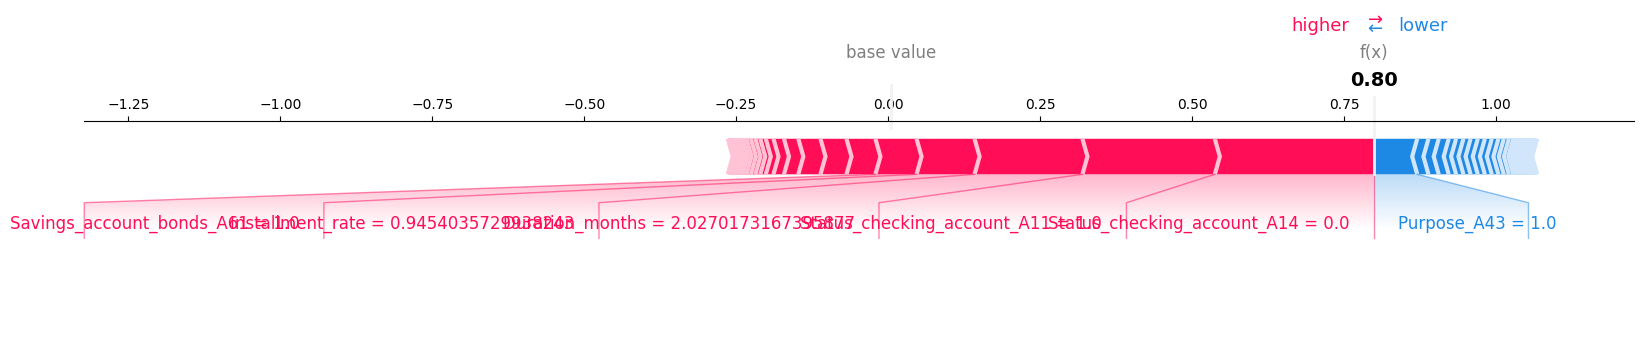

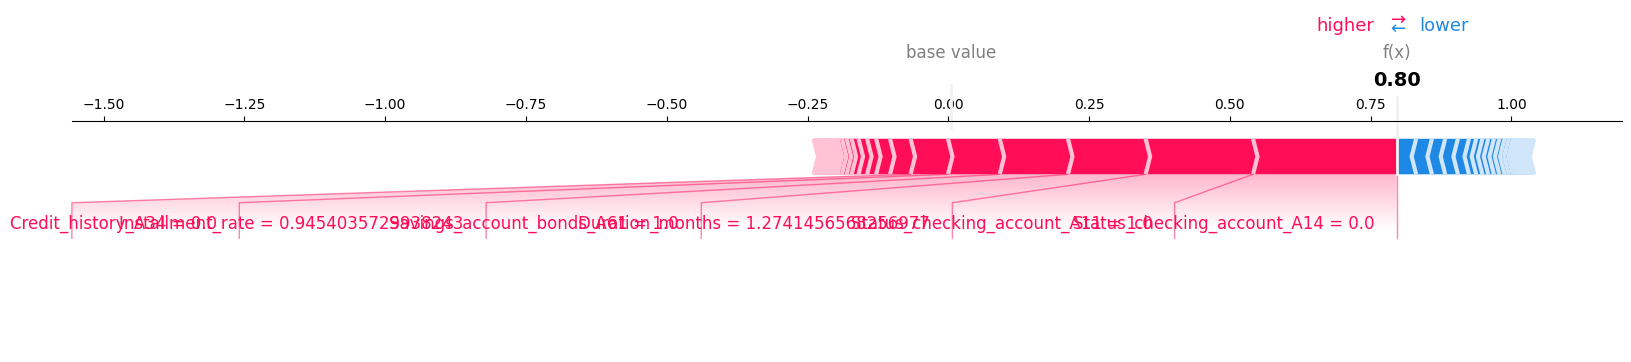

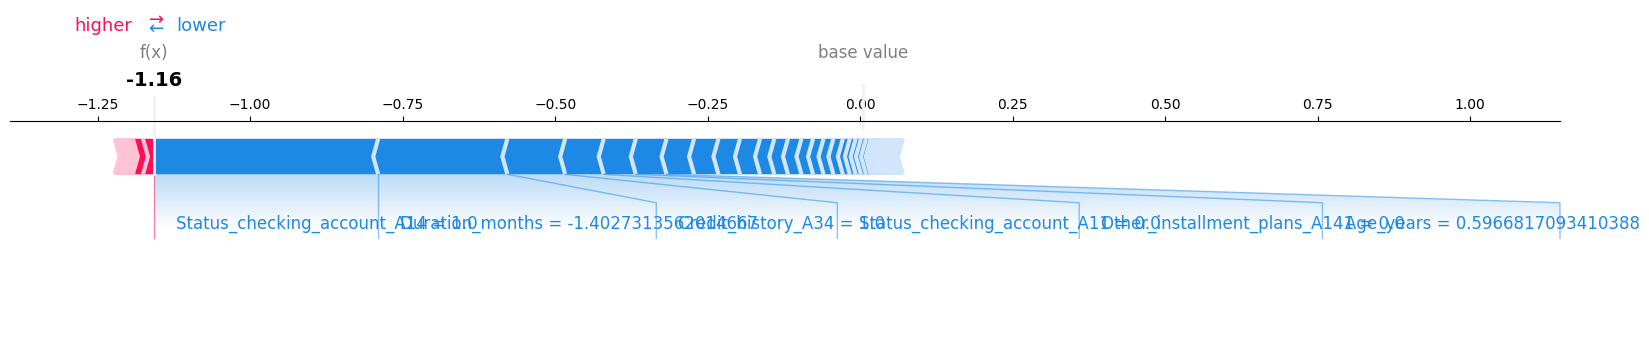

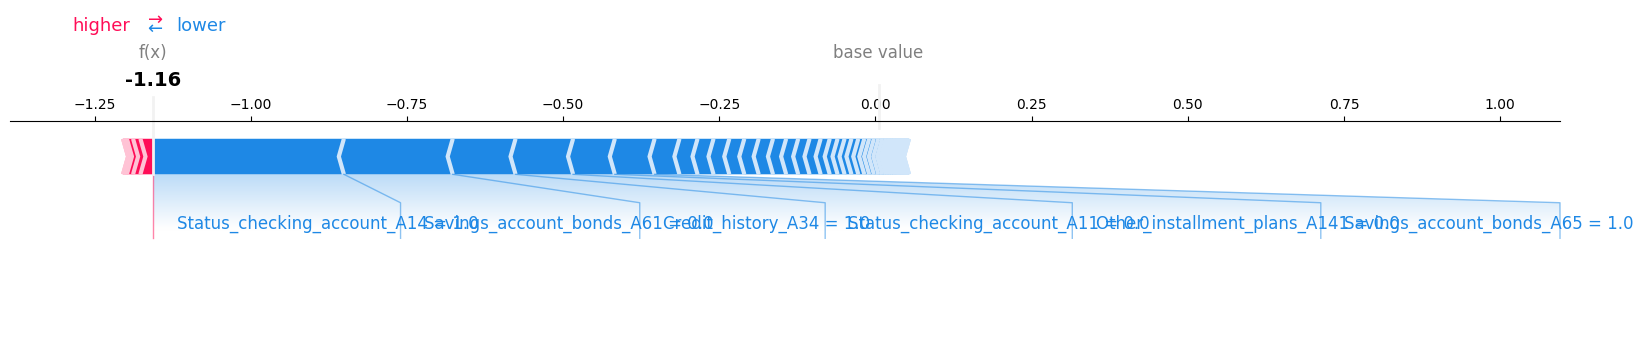

In [17]:
# ### CELL 13 - Select 5 profiles and create local SHAP explanations (text + plots)
# Select 3 high-risk + 2 low-risk by predicted probability
probs_test_raw = best.predict_proba(X_test_p)[:,1]
_test = X_test.reset_index(drop=True).copy(); _test['pred_prob'] = probs_test_raw; _test['true'] = y_test.reset_index(drop=True)
profiles_high = _test.sort_values('pred_prob', ascending=False).head(3)
profiles_low = _test.sort_values('pred_prob', ascending=True).head(2)
profiles = pd.concat([profiles_high, profiles_low])


local_reports = {}
for idx in profiles.index:
    row_vec = X_test_p[idx:idx+1]
    sv = explainer.shap_values(row_vec)
    sv_arr = sv[1][0] if isinstance(sv, list) else sv[0]
    contribs = list(zip(feature_names, sv_arr))
    contribs_sorted = sorted(contribs, key=lambda t: abs(t[1]), reverse=True)[:10]
    local_reports[int(idx)] = {'pred_prob': float(_test.loc[idx,'pred_prob']), 'true': int(_test.loc[idx,'true']), 'top_contribs': [{'feature':f,'shap':float(v)} for f,v in contribs_sorted]}
    # force plot saved as PNG via matplotlib
    shap.initjs()
    fig = shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, (list,tuple)) else explainer.expected_value, sv_arr, row_vec, feature_names=feature_names, matplotlib=True)
    plt.savefig(os.path.join(OUT,f'force_plot_{idx}.png'))
    plt.close()


with open(os.path.join(OUT,'local_shap_reports.json'),'w') as f:
    json.dump(local_reports, f, indent=2)

In [18]:
# ### CELL 14 - LIME local explanations for 2 profiles and comparison
lime_exp = LimeTabularExplainer(training_data=X_train_res, feature_names=feature_names, class_names=['no_default','default'], discretize_continuous=True, random_state=RND)
lime_reports = {}
for idx in profiles.index[:2]:
    row = X_test_p[idx]
    exp = lime_exp.explain_instance(row, best.predict_proba, num_features=10)
    lime_reports[int(idx)] = {'as_list': exp.as_list(), 'pred_prob': float(_test.loc[idx,'pred_prob']), 'true': int(_test.loc[idx,'true'])}
with open(os.path.join(OUT,'local_lime_reports.json'),'w') as f:
    json.dump(lime_reports, f, indent=2)

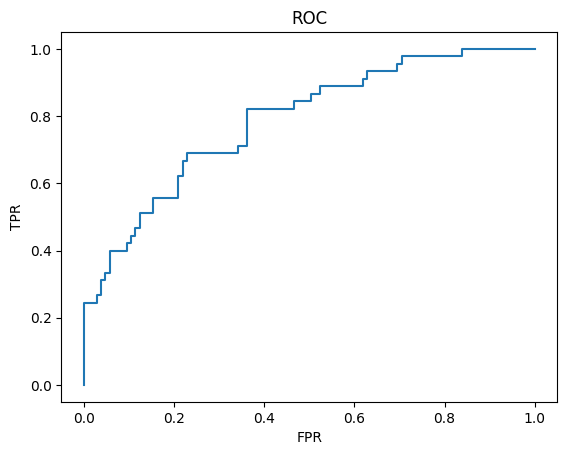

In [19]:
# ### CELL 15 - Plots: ROC, Precision-Recall, Confusion Matrix
# ROC
from sklearn.metrics import roc_curve, auc, precision_recall_curve
fpr, tpr, _ = roc_curve(y_test, probs_test)
plt.figure(); plt.plot(fpr, tpr); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.savefig(os.path.join(OUT,'roc.png'))



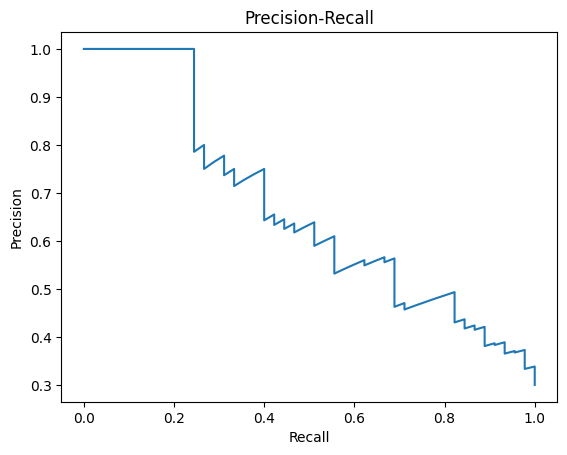

In [20]:
# Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, probs_test)
plt.figure(); plt.plot(rec, prec); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall'); plt.savefig(os.path.join(OUT,'pr.png'))

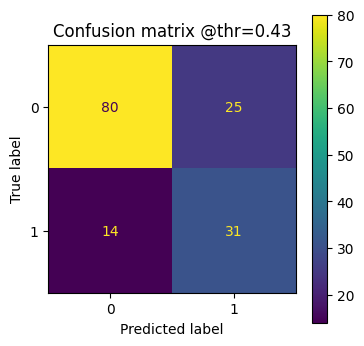

In [21]:
# Confusion matrix at chosen threshold
import numpy as np
thr = float(open(os.path.join(OUT,'chosen_threshold.txt')).read())
pred_thr = (probs_test >= thr).astype(int)
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred_thr)
fig, ax = plt.subplots(figsize=(4,4)); disp = ConfusionMatrixDisplay(cm).plot(ax=ax); plt.title(f'Confusion matrix @thr={thr}'); fig.savefig(os.path.join(OUT,'confusion_matrix.png'))

In [22]:
# ### CELL 16 - Executive summary & recommendations (auto-generated template)
# Build a concise 1-page executive summary using SHAP top features and model performance
with open(os.path.join(OUT,'report.md'),'w') as f:
    f.write('# Executive summary - German Credit Risk (UCI)\n\n')
    f.write('**Model:** LightGBM (tuned) with SHAP explanations.\n\n')
    f.write('**Performance (test):**\n')
    f.write(f'- AUC: {roc_auc_score(y_test, probs_test):.3f}\n')
    f.write(f'- F1 (at threshold {best_thr:.2f}): {f1_score(y_test, (probs_test>=best_thr).astype(int)):.3f}\n')
    f.write('\n**Top drivers (global SHAP):**\n')
    for i,row in shap_df.head(7).iterrows():
        f.write(f'- {row["feature"]}: mean |SHAP| = {row["mean_abs_shap"]:.6f}\n')
    f.write('\n**Top underwriting recommendations:**\n')
    f.write('- Strengthen review for applicants with high values in the top SHAP drivers.\n')
    f.write('- Consider re-pricing/raising interest or decreasing loan amount for high-risk segments.\n')
    f.write('- Add manual review for borderline profiles identified by local SHAP force plots.\n')

In [23]:
# ### CELL 17 - Save everything to a zip for download
import shutil
shutil.make_archive('/content/credit_project_outputs','zip', OUT)
print('All outputs saved to', OUT, 'and /content/credit_project_outputs.zip')


# End of script
print('Done. Open and run this notebook in Colab. All outputs will be in /content/credit_project_outputs/')

All outputs saved to /content/credit_project_outputs and /content/credit_project_outputs.zip
Done. Open and run this notebook in Colab. All outputs will be in /content/credit_project_outputs/
